# Reference

-   [FRED](https://fred.stlouisfed.org/searchresults/?st=ICE%20BofA)
-   [Gemini](https://gemini.google.com/app/a0cd28b75b80675e?utm_source=app_launcher&utm_medium=owned&utm_campaign=base_all)
-   [Gemini](https://gemini.google.com/app/0da10f614b7e7434?utm_source=app_launcher&utm_medium=owned&utm_campaign=base_all)


# MSCI Kokusai Constituents Macro Factor Model Ver3

## 回帰モデル

$$
R_i - R_f = \alpha
+ \beta_{\mathrm{mkt}}F_{\mathrm{mkt}}
+ \left[\beta_{\mathrm{level}}F_{\mathrm{level}}
+ \beta_{\mathrm{slope}}F_{\mathrm{slope}}
+ \beta_{\mathrm{curvature}}F_{\mathrm{curvature}}\right]
+ \beta_{X}F_{X}
+ \beta_{\mathrm{Inflation}}F_{\mathrm{Inflation}}
+ \epsilon_{i}
$$

-   $R_i$: 個別銘柄リターン
-   $R_f$: リスクフリーレート（米国 3 ヶ月物財務省短期証券 TBill）、日次リターン計測用。FRED シリーズは`DTB3`。長期の場合は 10 年物財務省長期証券を使用。
    -   年率ベースであるため、日次に変換。
-   $\beta_{\mathrm{mkt}}$: マーケット(MSCI Kokusai)ベータ。リスクフリーレートからの指数の超過収益を使う($R_{\mathrm{mkt}} - R_f$)。

### 金利ベータ

-   $\beta_{\mathrm{level}}$: US 金利データを主成分分析したのちの第 1 主成分(level)によるベータ
-   $\beta_{\mathrm{slope}}$: 第 2 主成分(slope)によるベータ
-   $\beta_{\mathrm{curvature}}$: 第 3 主成分(curvature)によるベータ

### クレジット orVIX ベータ: $\beta_{X}$

次の 1 または 2 を使用。

1.  $\beta_{\mathrm{FtoQ}}$: Flight to Quality ファクターによるベータ。

    定義は米国ハイイールド債スプレッド（FRED シリーズ:`BAMLH0A0HYM2` ）と米国投資適格級スプレッド（FRED シリーズ`BAMLC0A0CM`）の差分。"質への逃避"をモデル化したもの。このファクターが拡大する時、安全な投資適格債に比べて、リスクの高いハイイールド債を極端に避けている（+より高いリスクプレミアムを要求している）ことを意味する。これは市場の恐怖感を抽出したファクターとなりうる。

    企業の倒産リスクをどれだけ深刻に捉えているかを直接反映する。実際の売買の**行動の結果**が FtoQ ファクターに現れる。また、リスクの識別・選別という情報を含み、単にリスクオフになっているだけでなく、**質の低い社債が質の高い社債に比べてどれだけ余計に売られているか**を定量化している。

2.  $\beta_{\mathrm{VIX}}$: VIX 指数によるベータ。FRED シリーズは`VIXCLS`。

    S&P 500 の株価が将来どれだけ大きく変動するかという市場予想を反映する。これは企業の信用リスクだけでなく、地政学リスクや政治不安といった不確実性にも反応する。VIX は将来の変動を予想してプットオプションなどを買う行動の結果である。よって VIX が FtoQ に先行して急騰することもある。

### インフレベータ

-   $\beta_{\mathrm{Inflation}}$: インフレファクターベータ。5 年または 10 年ブレークイーブン・インフレ率を使う。
    -   FRED シリーズは`T5YIE`（5 年） or `T10YIE`（10 年）。

### 直行化

[Google Document を参照](https://docs.google.com/document/d/1OJ1hipUb0jYnwNXVZmq4FhBTmOqx0nSz0VpI-uF8PRQ/edit?tab=t.0)


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import polars as pl
from pathlib import Path
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MultipleLocator
import statsmodels.api as sm
import seaborn as sns
import json
from pprint import pprint
import os
import sys
from sklearn.decomposition import PCA
from dotenv import load_dotenv
from dateutil.relativedelta import relativedelta
from datetime import datetime, date, timedelta
from typing import List
from fredapi import Fred
from tqdm import tqdm
from data_check_utils import calculate_missing_stats, extract_dates_in_range
from database_utils import (
        get_table_names,
        step1_load_file_to_db,
        step2_create_variable_tables,
        step3_create_return_table
    )
from make_factor import orthogonalize
from data_prepare import createDB_bpm_and_factset_code
from concurrent.futures import ThreadPoolExecutor
from fred_database_utils import (
        store_fred_database,
        get_fred_ids_from_file,
        load_data_from_database,
    )
from us_treasury import (
        plot_us_interest_rates_and_spread,
        analyze_yield_curve_pca,
        plot_loadings_and_explained_variance,
        load_yield_data_from_database,
    )
from make_factor import make_descriptor_dataframe, orthogonalize_all_descriptors

import warnings
warnings.simplefilter("ignore")


Q_DIR = Path().cwd().parent
DATA_DIR = Q_DIR / "data" / "MSCI_KOKUSAI"
PRJ_DIR = Q_DIR / "A_001"
# Factset Benchmark directory
BM_DIR = Q_DIR / "data/Factset/Benchmark"
FRED_DIR = Q_DIR / "data/FRED"
print(f"FRED directory: {FRED_DIR}")

FRED_API = os.getenv("FRED_API_KEY")

# Prepare FRED Data
series_id_list = get_fred_ids_from_file(FRED_DIR / "fred_series.json")
db_path = FRED_DIR / "FRED.db"
store_fred_database(db_path=db_path, series_id_list=series_id_list, FRED_API=FRED_API)


FRED directory: /Users/yukihata/Desktop/papers/Quants/data/FRED
--- FREDデータの差分更新を開始 (データベース: 'FRED.db') ---
テーブル 'SP500' の最終日: 2025-09-10 00:00:00。これ以降のデータを取得します。
	FREDシリーズ 'SP500' を取得中 (開始日: 2025-09-11)...
	シリーズ 'SP500' に 7 件の新規データを追加しました。
テーブル 'CPIAUCSL' の最終日: 2025-07-01 00:00:00。これ以降のデータを取得します。
	FREDシリーズ 'CPIAUCSL' を取得中 (開始日: 2025-07-02)...
	シリーズ 'CPIAUCSL' に 2 件の新規データを追加しました。
テーブル 'DFF' の最終日: 2025-09-09 00:00:00。これ以降のデータを取得します。
	FREDシリーズ 'DFF' を取得中 (開始日: 2025-09-10)...
	シリーズ 'DFF' に 9 件の新規データを追加しました。
テーブル 'FEDFUNDS' の最終日: 2025-08-01 00:00:00。これ以降のデータを取得します。
	FREDシリーズ 'FEDFUNDS' を取得中 (開始日: 2025-08-02)...
	シリーズ 'FEDFUNDS' に 1 件の新規データを追加しました。
テーブル 'SOFR' の最終日: 2025-09-09 00:00:00。これ以降のデータを取得します。
	FREDシリーズ 'SOFR' を取得中 (開始日: 2025-09-10)...
	シリーズ 'SOFR' に 7 件の新規データを追加しました。
テーブル 'DPRIME' の最終日: 2025-09-09 00:00:00。これ以降のデータを取得します。
	FREDシリーズ 'DPRIME' を取得中 (開始日: 2025-09-10)...
	シリーズ 'DPRIME' に 7 件の新規データを追加しました。
テーブル 'DTB3' の最終日: 2025-09-09 00:00:00。これ以降のデータを取得します。
	FREDシリーズ 'DTB3' を取得中 (開始日: 

## Prepare Data


### Return data


#### MSCI Kokusai Constituents


In [ ]:
db_path = DATA_DIR / "MSCI_KOKUSAI_Price_Daily.db"
conn = sqlite3.connect(db_path)
return_secs = pd.read_sql(
    "SELECT * FROM FG_PRICE_Daily ORDER BY date", con=conn, parse_dates=["date"]
).assign(log_value=lambda row: np.log(row["value"]))
return_secs["Return"] = return_secs.groupby("P_SYMBOL")["log_value"].diff()
return_secs = return_secs[["date", "P_SYMBOL", "Return"]].dropna(
    how="any", ignore_index=True
)
display(return_secs)


,date,P_SYMBOL,Return
0,2005-08-23,0HSW-GB,-0.009018
1,2005-08-23,0II3.XX1-GB,-0.000887
2,2005-08-23,0MDJ-GB,0.002397
3,2005-08-23,0N1N-GB,-0.005587
4,2005-08-23,0N3I-GB,-0.012804
...,...,...,...
11207574,2025-08-25,ZION-US,0.000895
11207575,2025-08-25,ZM-US,-0.013674
11207576,2025-08-25,ZS-US,-0.010532
11207577,2025-08-25,ZTS-US,-0.009172


### Calculate Excess Return


In [ ]:
db_path = FRED_DIR / "FRED.db"
conn = sqlite3.connect(db_path)
risk_free_rate = pd.read_sql(
    "SELECT * FROM DTB3", con=conn, parse_dates=["date"]
).assign(
    DTB3=lambda row: row["DTB3"].div(365 * 100)
)  # convert to daily data
conn.close()
print("Risk free rate(DTB3)")
display(risk_free_rate)


excess_return_secs = (
    pd.merge(return_secs, risk_free_rate, on=["date"], how="left")
    .dropna(how="any", ignore_index=True)
    .assign(Excess_Return=lambda row: row["Return"].sub(row["DTB3"]))
)
print("Excess return of securities")
display(excess_return_secs)


Risk free rate(DTB3)


,date,DTB3
0,1954-01-04,0.000036
1,1954-01-05,0.000035
2,1954-01-06,0.000035
3,1954-01-07,0.000036
4,1954-01-08,0.000036
...,...,...
18686,2025-08-19,0.000113
18687,2025-08-20,0.000113
18688,2025-08-21,0.000113
18689,2025-08-22,0.000112


Excess return of securities


,date,P_SYMBOL,Return,DTB3,Excess_Return
0,2005-08-23,0HSW-GB,-0.009018,0.000095,-0.009112
1,2005-08-23,0II3.XX1-GB,-0.000887,0.000095,-0.000982
2,2005-08-23,0MDJ-GB,0.002397,0.000095,0.002303
3,2005-08-23,0N1N-GB,-0.005587,0.000095,-0.005682
4,2005-08-23,0N3I-GB,-0.012804,0.000095,-0.012899
...,...,...,...,...,...
10954956,2025-08-25,ZION-US,0.000895,0.000112,0.000782
10954957,2025-08-25,ZM-US,-0.013674,0.000112,-0.013786
10954958,2025-08-25,ZS-US,-0.010532,0.000112,-0.010644
10954959,2025-08-25,ZTS-US,-0.009172,0.000112,-0.009285


Excess return of MSCI Kokusai Index


,date,P_SYMBOL,Return,DTB3,Factor_Market
0,2005-08-26,MSCI Kokusai Index (World ex Japan),-0.004817,0.000095,-0.004912
1,2005-08-29,MSCI Kokusai Index (World ex Japan),0.002335,0.000095,0.002240
2,2005-08-30,MSCI Kokusai Index (World ex Japan),-0.003790,0.000095,-0.003885
3,2005-08-31,MSCI Kokusai Index (World ex Japan),0.012329,0.000094,0.012235
4,2005-09-01,MSCI Kokusai Index (World ex Japan),0.008984,0.000093,0.008891
...,...,...,...,...,...
4988,2025-08-19,MSCI Kokusai Index (World ex Japan),-0.003922,0.000113,-0.004035
4989,2025-08-20,MSCI Kokusai Index (World ex Japan),-0.001473,0.000113,-0.001586
4990,2025-08-21,MSCI Kokusai Index (World ex Japan),-0.003438,0.000113,-0.003551
4991,2025-08-22,MSCI Kokusai Index (World ex Japan),0.014586,0.000112,0.014473


### Integrate factor data

#### Market Factor, Yield, FtoQ, Inflation

<!--
#### 金利変動幅に対して PCA(Leve, Slope, Curvature) -->


,Factor_Market,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30,FtoQ_Shock,Inflation_Shock
date,,,,,,,,,,,,,,
2005-08-26,-0.004912,3.36,3.55,3.82,3.90,4.06,4.07,4.09,4.13,4.20,4.46,4.38,-0.03,0.01
2005-08-29,0.002240,3.42,3.54,3.83,3.91,4.06,4.07,4.08,4.13,4.20,4.45,4.37,0.03,0.02
2005-08-30,-0.003885,3.40,3.54,3.79,3.85,3.97,4.01,4.03,4.08,4.16,4.43,4.34,0.10,0.04
2005-08-31,0.012235,3.41,3.52,3.74,3.77,3.84,3.83,3.87,3.93,4.02,4.30,4.23,0.18,-0.08
2005-09-01,0.008891,3.35,3.48,3.62,3.66,3.72,3.80,3.85,3.91,4.02,4.31,4.28,0.03,0.04


,Factor_Market,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30,FtoQ_Shock,Inflation_Shock
date,,,,,,,,,,,,,,
2007-09-21,0.004508,3.24,3.74,4.10,4.09,4.06,4.15,4.31,4.44,4.64,4.95,4.89,-0.03,-0.02
2007-09-24,-0.002070,3.35,3.84,4.11,4.09,4.05,4.14,4.31,4.44,4.63,4.94,4.88,-0.05,-0.03
2007-09-25,-0.003268,3.34,3.79,4.06,4.04,4.00,4.09,4.26,4.41,4.63,4.94,4.89,0.07,-0.01
2007-09-26,0.005343,3.25,3.73,4.06,4.03,3.97,4.07,4.27,4.43,4.63,4.95,4.90,-0.02,0.00
2007-09-27,0.007224,3.30,3.71,4.07,4.03,3.95,4.02,4.22,4.37,4.58,4.89,4.84,0.01,0.02


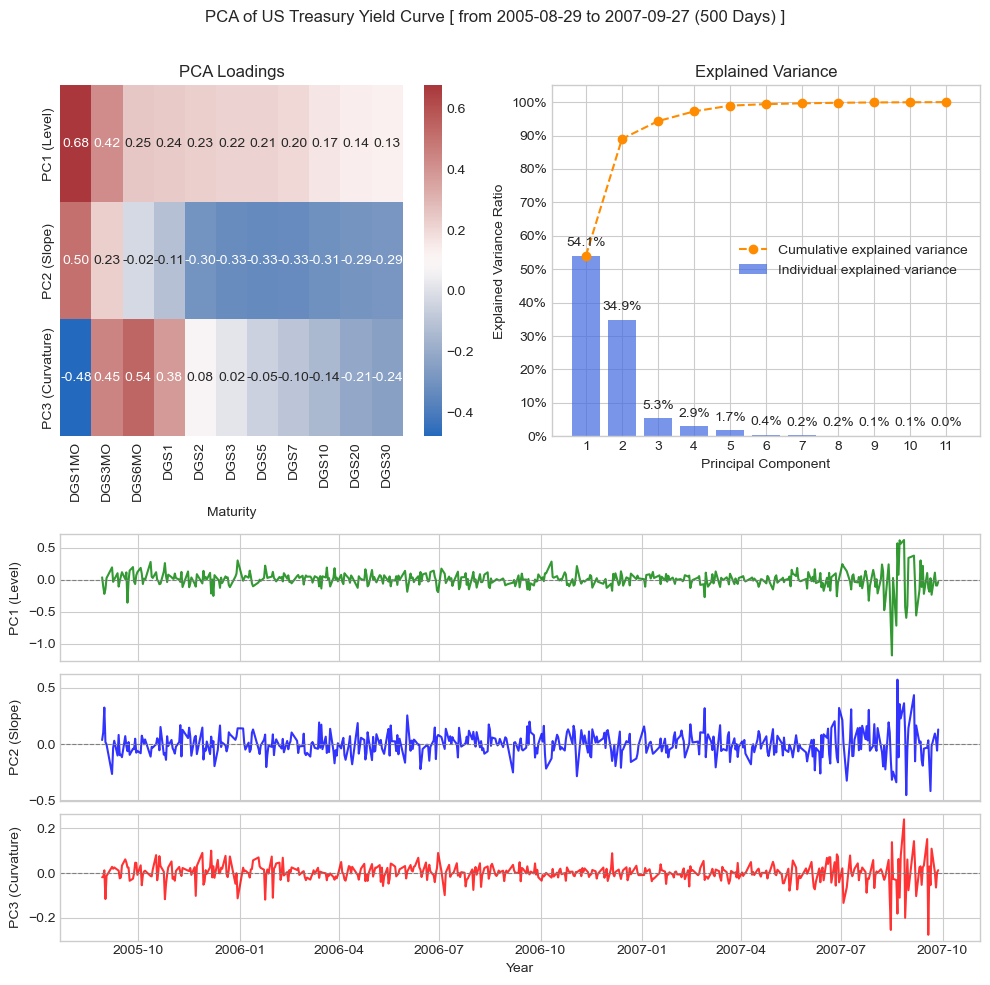

,Factor_Market,FtoQ_Shock,Inflation_Shock,Level_Shock,Slope_Shock,Curvature_Shock
date,,,,,,
2005-08-30,-0.003885,0.10,0.04,-0.141805,-0.068377,0.000606
2005-08-31,0.012235,0.18,-0.08,-0.115784,-0.220041,0.030310
2005-09-01,0.008891,0.03,0.04,0.072886,0.306635,-0.128691
2005-09-02,-0.000023,0.00,0.03,0.173449,0.020593,0.103217
2005-09-07,0.001988,-0.03,0.02,0.166607,0.262607,0.041018
...,...,...,...,...,...,...
2007-09-21,0.004508,-0.03,-0.02,-0.257063,-0.398779,0.163404
2007-09-24,-0.002070,-0.05,-0.03,0.343523,-0.112285,-0.106484
2007-09-25,-0.003268,0.07,-0.01,-0.199878,0.047965,-0.067622


In [ ]:
# yield data
db_path = FRED_DIR / "FRED.db"
df_yield = load_yield_data_from_database(db_path=db_path)

# Flight to Quality Factor
df_FtoQ = load_data_from_database(
    db_path=db_path, series_id_list=["BAMLH0A0HYM2", "BAMLC0A0CM"]
)
df_FtoQ = (
    pd.pivot(df_FtoQ, index="date", columns="variable", values="value")
    .sort_index()
    .assign(FtoQ=lambda row: row["BAMLH0A0HYM2"].sub(row["BAMLC0A0CM"]))
    .assign(FtoQ_Shock=lambda row: row["FtoQ"].diff())
).dropna(how="any")[["FtoQ_Shock"]]

# Inflation Factor
df_Inflation = (
    load_data_from_database(db_path=db_path, series_id_list=["T10YIE"])
    .set_index("date")
    .assign(Inflation_Shock=lambda row: row["value"].diff())
    .dropna()
)[["Inflation_Shock"]]


# Factor_Market dataにマージする
df_factor = pd.merge(
    excess_return_index.set_index("date")[["Factor_Market"]],
    df_yield,
    left_index=True,
    right_index=True,
)
df_factor = pd.merge(df_factor, df_FtoQ, left_index=True, right_index=True)
df_factor = pd.merge(df_factor, df_Inflation, left_index=True, right_index=True)

date_list = [d.strftime("%Y-%m-%d") for d in df_factor.index.tolist()]

# ====== 分析期間を指定 =======
start_date = date_list[0]
end_date = date_list[500]
df_factor = df_factor.loc[start_date:end_date]

display(df_factor.head())
display(df_factor.tail())


# Check: loading and contribution
plot_loadings_and_explained_variance(
    df_yield=df_factor[[s for s in df_factor.columns if s.startswith("DGS")]]
)

# PCA and PCA Shock
df_pca, pca = analyze_yield_curve_pca(
    df_yield=df_factor[[s for s in df_factor.columns if s.startswith("DGS")]]
)
df_pca = df_pca.assign(
    Level_Shock=lambda row: row["Level"].diff(),
    Slope_Shock=lambda row: row["Slope"].diff(),
    Curvature_Shock=lambda row: row["Curvature"].diff(),
).dropna()
# display(df_pca)

# merge PCA data
df_factor = pd.merge(df_factor, df_pca, left_index=True, right_index=True)
df_factor = df_factor[
    [col for col in df_factor.columns if ("Factor" in col) | ("Shock" in col)]
]
display(df_factor)


# plot_us_interest_rates_and_spread(
#     db_path=db_path, start_date=start_date, end_date=end_date
# )


### 直行化


In [ ]:
# 金利ファクター直行化
df_factor["Factor_Level"] = orthogonalize(
    df_factor["Level_Shock"], df_factor["Factor_Market"]
)
df_factor["Factor_Slope"] = orthogonalize(
    df_factor["Slope_Shock"], df_factor["Factor_Market"]
)
df_factor["Factor_Curvature"] = orthogonalize(
    df_factor["Curvature_Shock"], df_factor["Factor_Market"]
)

# FtoQファクター直行化: マーケットと金利ファクターに対して直行化
regressors_ftoq = df_factor[
    ["Factor_Market", "Factor_Level", "Factor_Slope", "Factor_Curvature"]
]
df_factor["Factor_FtoQ"] = orthogonalize(
    df_factor["FtoQ_Shock"], regressors=regressors_ftoq
)

# インフレファクター直行化: マーケット、金利ファクター、FtoQファクターに対して直行化
regressors_inflation = df_factor[
    ["Factor_Market", "Factor_Level", "Factor_Slope", "Factor_Curvature", "Factor_FtoQ"]
]
df_factor["Factor_Inflation"] = orthogonalize(
    df_factor["Inflation_Shock"], regressors=regressors_inflation
)

df_factor = df_factor[
    [
        "Factor_Market",
        "Factor_Level",
        "Factor_Slope",
        "Factor_Curvature",
        "Factor_FtoQ",
        "Factor_Inflation",
    ]
].dropna(how="any")
display(df_factor)

# ファクター間の相関行列
print("=== Correlation Matrix ===")
display(df_factor.corr().round(4))


,Factor_Market,Factor_Level,Factor_Slope,Factor_Curvature,Factor_FtoQ,Factor_Inflation
date,,,,,,
2005-08-30,-0.003928,-0.126280,0.067160,0.003494,0.070098,0.050992
2005-08-31,0.012193,-0.157142,0.222630,0.022287,0.176398,-0.062295
2005-09-01,0.008849,0.043327,-0.304835,-0.134451,0.096245,0.040064
2005-09-02,-0.000064,0.175342,-0.020898,0.103490,0.010156,0.029343
2005-09-07,0.001946,0.161405,-0.262437,0.039930,0.014055,0.015572
...,...,...,...,...,...,...
2007-09-21,0.004463,-0.271145,0.399543,0.160613,-0.089340,-0.017791
2007-09-24,-0.002116,0.352655,0.111496,-0.104823,-0.039254,-0.038130
2007-09-25,-0.003314,-0.186519,-0.049037,-0.065150,0.052746,-0.001960


=== Correlation Matrix ===


,Factor_Market,Factor_Level,Factor_Slope,Factor_Curvature,Factor_FtoQ,Factor_Inflation
Factor_Market,1.0,0.0000,0.0000,0.0000,-0.0,-0.0
Factor_Level,0.0,1.0000,-0.1228,-0.0910,0.0,0.0
Factor_Slope,0.0,-0.1228,1.0000,-0.0673,-0.0,-0.0
Factor_Curvature,0.0,-0.0910,-0.0673,1.0000,-0.0,0.0
Factor_FtoQ,-0.0,0.0000,-0.0000,-0.0000,1.0,-0.0
Factor_Inflation,-0.0,0.0000,-0.0000,0.0000,-0.0,1.0


In [ ]:
security = "BKNG-US"
excess_return_security = excess_return_secs.loc[
    excess_return_secs["P_SYMBOL"] == security, ["date", "Excess_Return"]
].set_index("date")

display(excess_return_security)
df_data = pd.merge(
    excess_return_security,
    df_factor,
    left_index=True,
    right_index=True,
)
display(df_data)


,Excess_Return
date,
2005-08-26,0.008458
2005-08-29,0.014964
2005-08-30,-0.002013
2005-08-31,0.008275
2005-09-01,-0.020347
...,...
2025-08-19,0.009207
2025-08-20,0.009762
2025-08-21,0.012339


,Excess_Return,Factor_Market,Factor_Level,Factor_Slope,Factor_Curvature,Factor_FtoQ,Factor_Inflation
date,,,,,,,
2005-08-30,-0.002013,-0.003928,-0.126280,0.067160,0.003494,0.070098,0.050992
2005-08-31,0.008275,0.012193,-0.157142,0.222630,0.022287,0.176398,-0.062295
2005-09-01,-0.020347,0.008849,0.043327,-0.304835,-0.134451,0.096245,0.040064
2005-09-02,0.004603,-0.000064,0.175342,-0.020898,0.103490,0.010156,0.029343
2005-09-07,0.000812,0.001946,0.161405,-0.262437,0.039930,0.014055,0.015572
...,...,...,...,...,...,...,...
2007-09-21,0.028705,0.004463,-0.271145,0.399543,0.160613,-0.089340,-0.017791
2007-09-24,-0.019822,-0.002116,0.352655,0.111496,-0.104823,-0.039254,-0.038130
2007-09-25,0.021204,-0.003314,-0.186519,-0.049037,-0.065150,0.052746,-0.001960


In [ ]:
from us_treasury import align_pca_components


def calculate_rolling_betas(
    stock_price_series,
    df_raw_macro,
    window_size,
    yield_cols=[
        "DGS1MO",
        "DGS3MO",
        "DGS6MO",
        "DGS1",
        "DGS2",
        "DGS3",
        "DGS5",
        "DGS7",
        "DGS10",
        "DGS20",
        "DGS30",
    ],
):
    """
    ローリングウィンドウ内でファクター生成（PCA, 直交化）と回帰分析を全て実行し、
    時系列ベータを算出する統合関数。

    :param stock_price_series: pd.Series - 個別銘柄の株価時系列
    :param df_raw_macro: pd.DataFrame - 必要な全てのマクロ指標の元データ
    :param window_size: int - ローリングウィンドウのサイズ（営業日数）
    :param yield_cols: list - PCAに使用する金利カラム名
    :return: pd.DataFrame - 時間変動ベータ、アルファ、R2の時系列データ
    """
    # 株価リターンと超過リターンを計算
    stock_return = stock_price_series.pct_change()
    daily_rf = df_raw_macro["DTB3"] / 365
    stock_excess_return = (stock_return - daily_rf).rename("Excess_Return")

    # 分析に必要なデータを全て結合
    data = pd.concat([stock_excess_return, df_raw_macro], axis=1)

    # 結果を格納するリスト
    results = []

    # ローリング処理
    for t in tqdm(
        range(window_size, len(data)),
        desc=f"Rolling Betas for {stock_price_series.name}",
    ):
        df = data.iloc[t - window_size : t].copy()
        df.fillna(method="ffill", inplace=True)
        df.dropna(inplace=True)

        # --- ループ内でのファクター生成 ---
        # 1. マーケットファクター
        mkt_return = df["MSCI_KOKUSAI"].pct_change()
        factor_market = (mkt_return - df["daily_rf"]).rename("Factor_Market")

        # 2. 金利ファクター
        pca = PCA(n_components=3)
        pc_scores_raw = pca.fit_transform(df[yield_cols])
        pc_scores_aligned = align_pca_components(pca.components_, pc_scores_raw)
        df_pc = pd.DataFrame(
            pc_scores_aligned,
            index=df[yield_cols].index,
            columns=["Level", "Slope", "Curvature"],
        )

        level_shock = df_pc["Level"].diff()
        slope_shock = df_pc["Slope"].diff()
        curvature_shock = df_pc["Curvature"].diff()

        factor_level = orthogonalize(level_shock, factor_market)
        factor_slope = orthogonalize(slope_shock, factor_market)
        factor_curvature = orthogonalize(curvature_shock, factor_market)

        # 3. FtoQファクター
        ftoq = df["BAMLH0A0HYM2"] - df["BAMLC0A0CM"]
        ftoq_shock = ftoq.diff()
        factor_ftoq = orthogonalize(
            ftoq_shock,
            pd.concat(
                [factor_market, factor_level, factor_slope, factor_curvature], axis=1
            ),
        )

        # 4. インフレファクター
        inflation_shock = df["T10YIE"].diff()
        all_other_factors = pd.concat(
            [factor_market, factor_level, factor_slope, factor_curvature, factor_ftoq],
            axis=1,
        )
        factor_inflation = orthogonalize(inflation_shock, all_other_factors)

        # --- 回帰分析の実行 ---
        X = pd.concat(
            [
                factor_market,
                factor_level,
                factor_slope,
                factor_curvature,
                factor_ftoq,
                factor_inflation,
            ],
            axis=1,
        )
        X.columns = [
            "Market",
            "Level",
            "Slope",
            "Curvature",
            "FtoQ",
            "Inflation",
        ]  # カラム名を簡潔に

        analysis_data = pd.concat([df["Excess_Return"], X], axis=1).dropna()

        if len(analysis_data) < 50:
            continue  # データ不足の場合はスキップ

        Y_reg = analysis_data["Excess_Return"]
        X_reg = sm.add_constant(analysis_data.iloc[:, 1:])

        model = sm.OLS(Y_reg, X_reg).fit()

        # 結果を辞書として保存
        res = model.params.to_dict()
        res["r_squared_adj"] = model.rsquared_adj
        res["date"] = df.index[-1]
        results.append(res)

    # 結果をDataFrameに変換
    beta_history = pd.DataFrame(results).set_index("date")
    beta_history = beta_history.rename(columns={"const": "alpha"})

    return beta_history


,Factor_Market,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30,FtoQ_Shock,Inflation_Shock
date,,,,,,,,,,,,,,
2006-02-02,-0.009479,4.32,4.48,4.62,4.61,4.59,4.54,4.51,4.53,4.57,4.76,4.68,1.000000e-02,-0.02
2006-02-03,-0.006257,4.31,4.48,4.63,4.62,4.59,4.54,4.50,4.51,4.54,4.70,4.64,3.000000e-02,0.01
2006-02-06,0.000825,4.32,4.48,4.68,4.66,4.62,4.57,4.51,4.52,4.55,4.69,4.61,0.000000e+00,0.01
2006-02-07,-0.008079,4.33,4.49,4.67,4.65,4.61,4.57,4.52,4.54,4.57,4.73,4.64,4.440892e-16,0.00
2006-02-08,0.002948,4.34,4.50,4.67,4.66,4.64,4.61,4.55,4.55,4.56,4.75,4.67,-1.000000e-02,-0.06


,Factor_Market,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30,FtoQ_Shock,Inflation_Shock
date,,,,,,,,,,,,,,
2008-03-05,0.010547,1.91,1.53,1.75,1.72,1.66,1.91,2.59,3.10,3.70,4.55,4.60,-0.12,0.06
2008-03-06,-0.014665,1.73,1.39,1.61,1.59,1.53,1.77,2.50,3.00,3.62,4.52,4.57,0.03,0.01
2008-03-07,-0.010965,1.65,1.45,1.56,1.55,1.53,1.75,2.45,2.94,3.56,4.49,4.55,0.10,0.00
2008-03-10,-0.015329,1.63,1.35,1.45,1.46,1.47,1.67,2.37,2.84,3.46,4.39,4.45,0.11,0.01
2008-03-11,0.023832,1.82,1.48,1.64,1.67,1.74,1.93,2.61,3.04,3.60,4.48,4.53,-0.17,-0.01


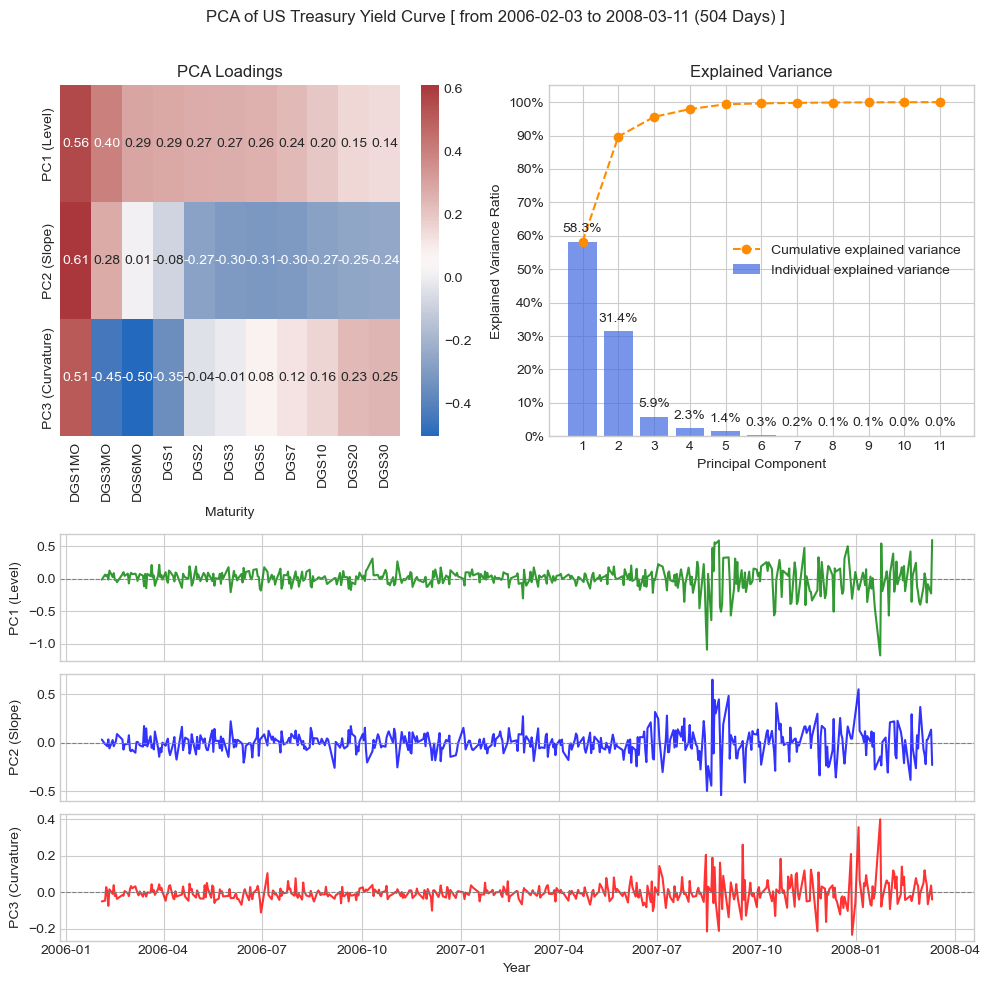

,Factor_Market,FtoQ_Shock,Inflation_Shock,Level_Shock,Slope_Shock,Curvature_Shock
date,,,,,,
2006-02-06,0.000825,0.000000e+00,0.01,0.077310,0.047854,-0.004026
2006-02-07,-0.008079,4.440892e-16,0.00,-0.026211,0.007085,-0.074346
2006-02-08,0.002948,-1.000000e-02,-0.06,0.024130,0.014161,0.023018
2006-02-09,0.003426,1.000000e-02,0.00,-0.073805,-0.070506,0.079581
2006-02-10,-0.001766,-3.000000e-02,0.01,0.136947,0.093173,-0.090499
...,...,...,...,...,...,...
2008-03-05,0.010547,-1.200000e-01,0.06,-0.088450,0.099033,0.047287
2008-03-06,-0.014665,3.000000e-02,0.01,-0.359948,-0.249895,0.031845
2008-03-07,-0.010965,1.000000e-01,0.00,0.281904,-0.007008,0.107043


,Factor_Market,Factor_Level,Factor_Slope,Factor_Curvature,Factor_FtoQ,Factor_Inflation
date,,,,,,
2006-02-06,0.000825,0.071046,0.046561,-0.004184,0.006529,0.009430
2006-02-07,-0.008079,0.030148,0.015342,-0.072301,-0.030952,-0.001051
2006-02-08,0.002948,0.002935,0.010591,0.022335,-0.003671,-0.060640
2006-02-09,0.003426,-0.098366,-0.074589,0.078779,0.002197,0.001969
2006-02-10,-0.001766,0.148902,0.094659,-0.090016,-0.020920,0.005761
...,...,...,...,...,...,...
2008-03-05,0.010547,-0.163096,0.087312,0.044723,-0.089784,0.053057
2008-03-06,-0.014665,-0.257266,-0.234573,0.035520,-0.070840,0.013860
2008-03-07,-0.010965,0.358562,0.004345,0.109803,0.071067,0.006082


In [ ]:
fred_db_path = FRED_DIR / "FRED.db"
benchmark_db_path = BM_DIR / "BM_Price_Daily.db"
df_descriptor = make_descriptor_dataframe(
    fred_db_path=fred_db_path, benchmark_db_path=benchmark_db_path
)
date_list = [d.strftime("%Y-%m-%d") for d in df_descriptor.index.tolist()]

# ====== 分析期間を指定 =======
start_index = 100
start_date = date_list[start_index]
end_date = date_list[start_index + 252 * 2]
df_descriptor = df_descriptor.loc[start_date:end_date]

display(df_descriptor.head())
display(df_descriptor.tail())


# Check: loading and contribution
plot_loadings_and_explained_variance(
    df_yield=df_descriptor[[s for s in df_descriptor.columns if s.startswith("DGS")]]
)

# PCA and PCA Shock
df_pca, pca = analyze_yield_curve_pca(
    df_yield=df_descriptor[[s for s in df_descriptor.columns if s.startswith("DGS")]]
)
df_pca = df_pca.assign(
    Level_Shock=lambda row: row["Level"].diff(),
    Slope_Shock=lambda row: row["Slope"].diff(),
    Curvature_Shock=lambda row: row["Curvature"].diff(),
).dropna()
# display(df_pca)

# merge PCA data
df_descriptor = pd.merge(df_descriptor, df_pca, left_index=True, right_index=True)
df_descriptor = df_descriptor[
    [col for col in df_descriptor.columns if ("Factor" in col) | ("Shock" in col)]
]
display(df_descriptor)


# plot_us_interest_rates_and_spread(
#     db_path=db_path, start_date=start_date, end_date=end_date
# )

df_factor = orthogonalize_all_descriptors(df_descriptor=df_descriptor)
display(df_factor)


,Factor_Market,Factor_Level,Factor_Slope,Factor_Curvature,Factor_FtoQ,Factor_Inflation
Factor_Market,1.0,-0.0000,-0.0000,-0.0000,0.0,-0.0
Factor_Level,-0.0,1.0000,0.1343,-0.0298,0.0,0.0
Factor_Slope,-0.0,0.1343,1.0000,0.0305,0.0,0.0
Factor_Curvature,-0.0,-0.0298,0.0305,1.0000,0.0,0.0
Factor_FtoQ,0.0,0.0000,0.0000,0.0000,1.0,-0.0
Factor_Inflation,-0.0,0.0000,0.0000,0.0000,-0.0,1.0


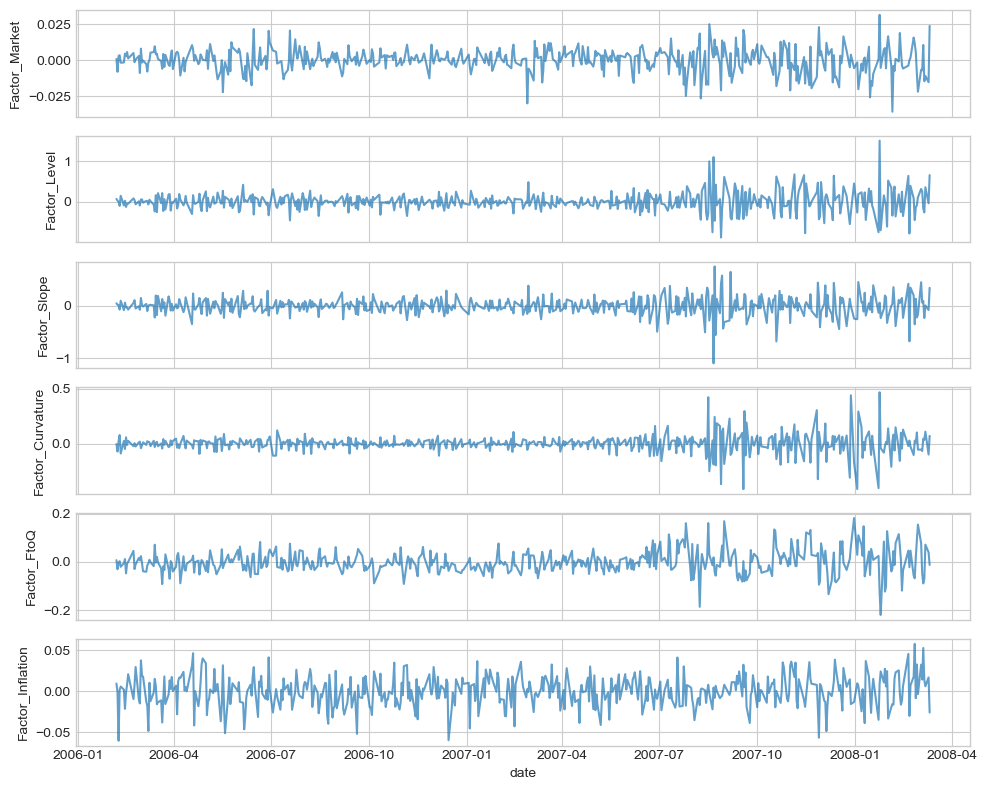

In [ ]:
display(df_factor.corr().round(4))

fig, axes = plt.subplots(6, 1, figsize=(10, 8), tight_layout=True, sharex=True)
for i, col in enumerate(df_factor.columns.tolist()):
    ax = axes[i]
    sns.lineplot(df_factor, x=df_factor.index, y=df_factor[col], alpha=0.7, ax=ax)
    ax.set_ylabel(col)

plt.show()
